## SMS Spam using python and TF-IDF sklearn.

### Import library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Read and preprocess

In [2]:
## file description
with open('desciption.txt') as f:
    print(f.read())

SMS Spam Collection v.1
-------------------------

1. DESCRIPTION
--------------

The SMS Spam Collection v.1 (hereafter the corpus) is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,574 messages, tagged acording being ham (legitimate) or spam. 

1.1. Compilation
----------------

This corpus has been collected from free or free for research sources at the Web:

- A collection of between 425 SMS spam messages extracted manually from the Grumbletext Web site. This is a UK forum in which cell phone users make public claims about SMS spam messages, most of them without reporting the very spam message received. The identification of the text of spam messages in the claims is a very hard and time-consuming task, and it involved carefully scanning hundreds of web pages. The Grumbletext Web site is: http://www.grumbletext.co.uk/
- A list of 450 SMS ham messages collected from Caroline Tag's PhD Theses available 

In [3]:
with open('SMSSpamCollection.txt') as f:
    data = f.read()
data = data.split('\n')
data.pop() ## remove last line with none values in dataset
data = [line.split('\t') for line in data]
data = pd.DataFrame(data, columns = ['label', 'text']) ## create DataFrame 
data.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
print('Numbers of sms in dataset: ', data.shape[0])

Numbers of sms in dataset:  5574


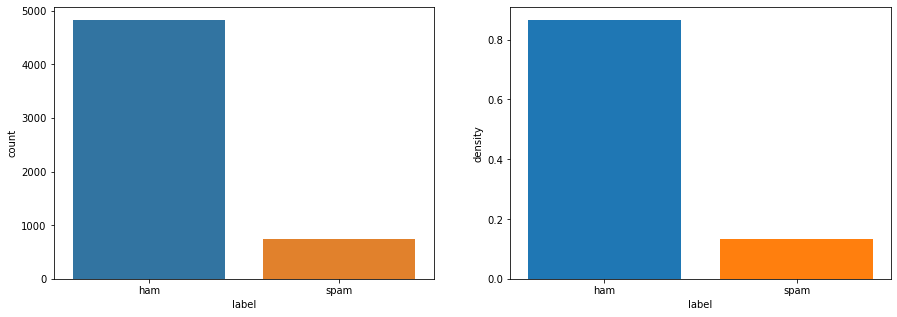

In [5]:
## The number of each class in dataset
f, ax = plt.subplots(1, 2, figsize = (15, 5))

sns.countplot(data = data, x = 'label', ax = ax[0])
ax[1].bar(x = ['ham', 'spam'], height = data['label'].value_counts()/data.shape[0], color = ['tab:blue', 'tab:orange'])
ax[1].set_xlabel('label')
ax[1].set_ylabel('density')
plt.show()

- `ham` is legitimate  messages and `spam` is spam messages

We can see this a an imbalance dataset. with imbalance dataset we can't use `accuracy` metric to evaluate performance of model. So, we can use F1 score to do this.

#### Preprocessing text

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [7]:
def getFreq(texts):
    Cvec = CountVectorizer(stop_words= 'english')
    Cvec_df = Cvec.fit_transform(texts)
    words = Cvec.get_feature_names()
    freq = Cvec_df.toarray().sum(axis = 0)
    df = pd.DataFrame({'word': words, 'Freq': freq})
    return df

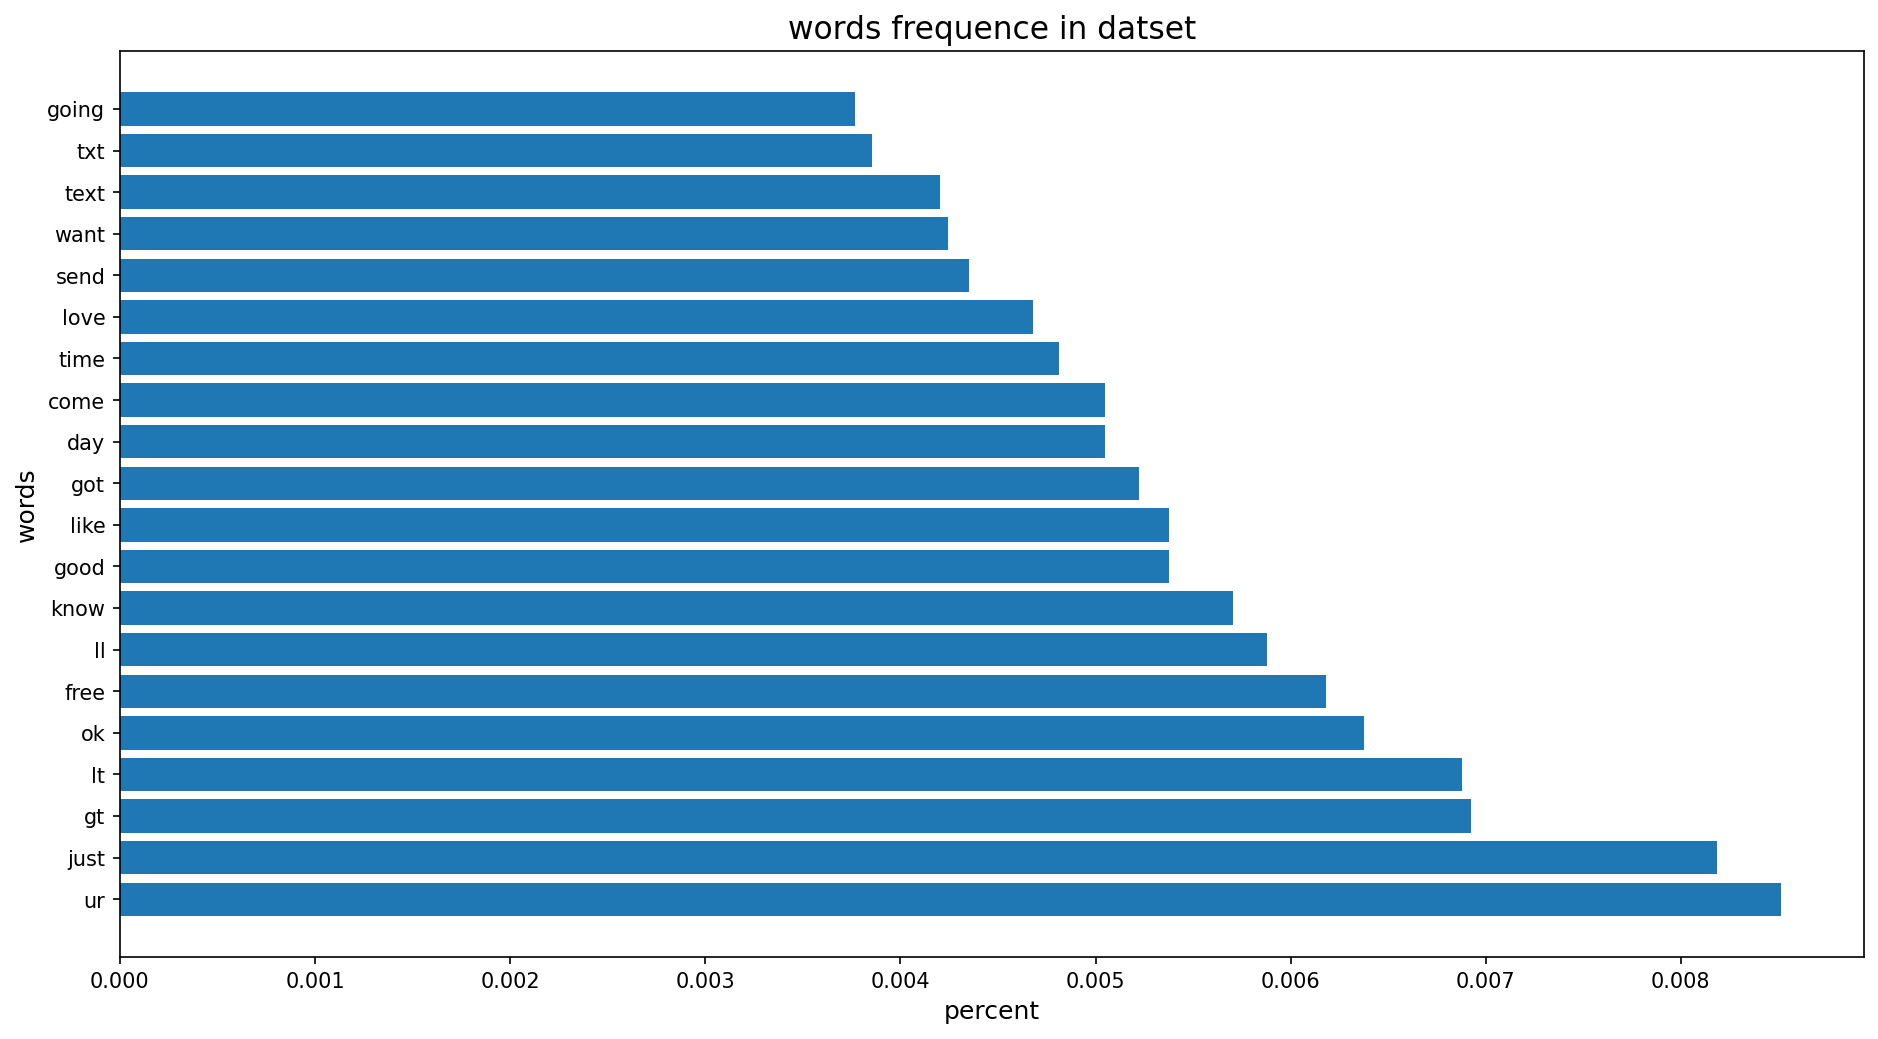

In [8]:
word_freq = getFreq(data['text'].values)
top_20_words = word_freq.sort_values('Freq', ascending= False).head(20)
plt.figure(figsize = (15, 8), dpi = 150)
plt.barh(y = top_20_words['word'], width = top_20_words['Freq']/word_freq['Freq'].sum())
plt.xlabel('percent', size = 12)
plt.ylabel('words', size = 12)
plt.title('words frequence in datset', size = 15)
plt.show()

#### Let's see word frequence in each class

In [9]:
## class ham(legitimate messages)
ham = data[data['label'] == 'ham']['text'].values
ham_freq = getFreq(ham)
top_20_words = ham_freq.sort_values('Freq', ascending= False).head(20)

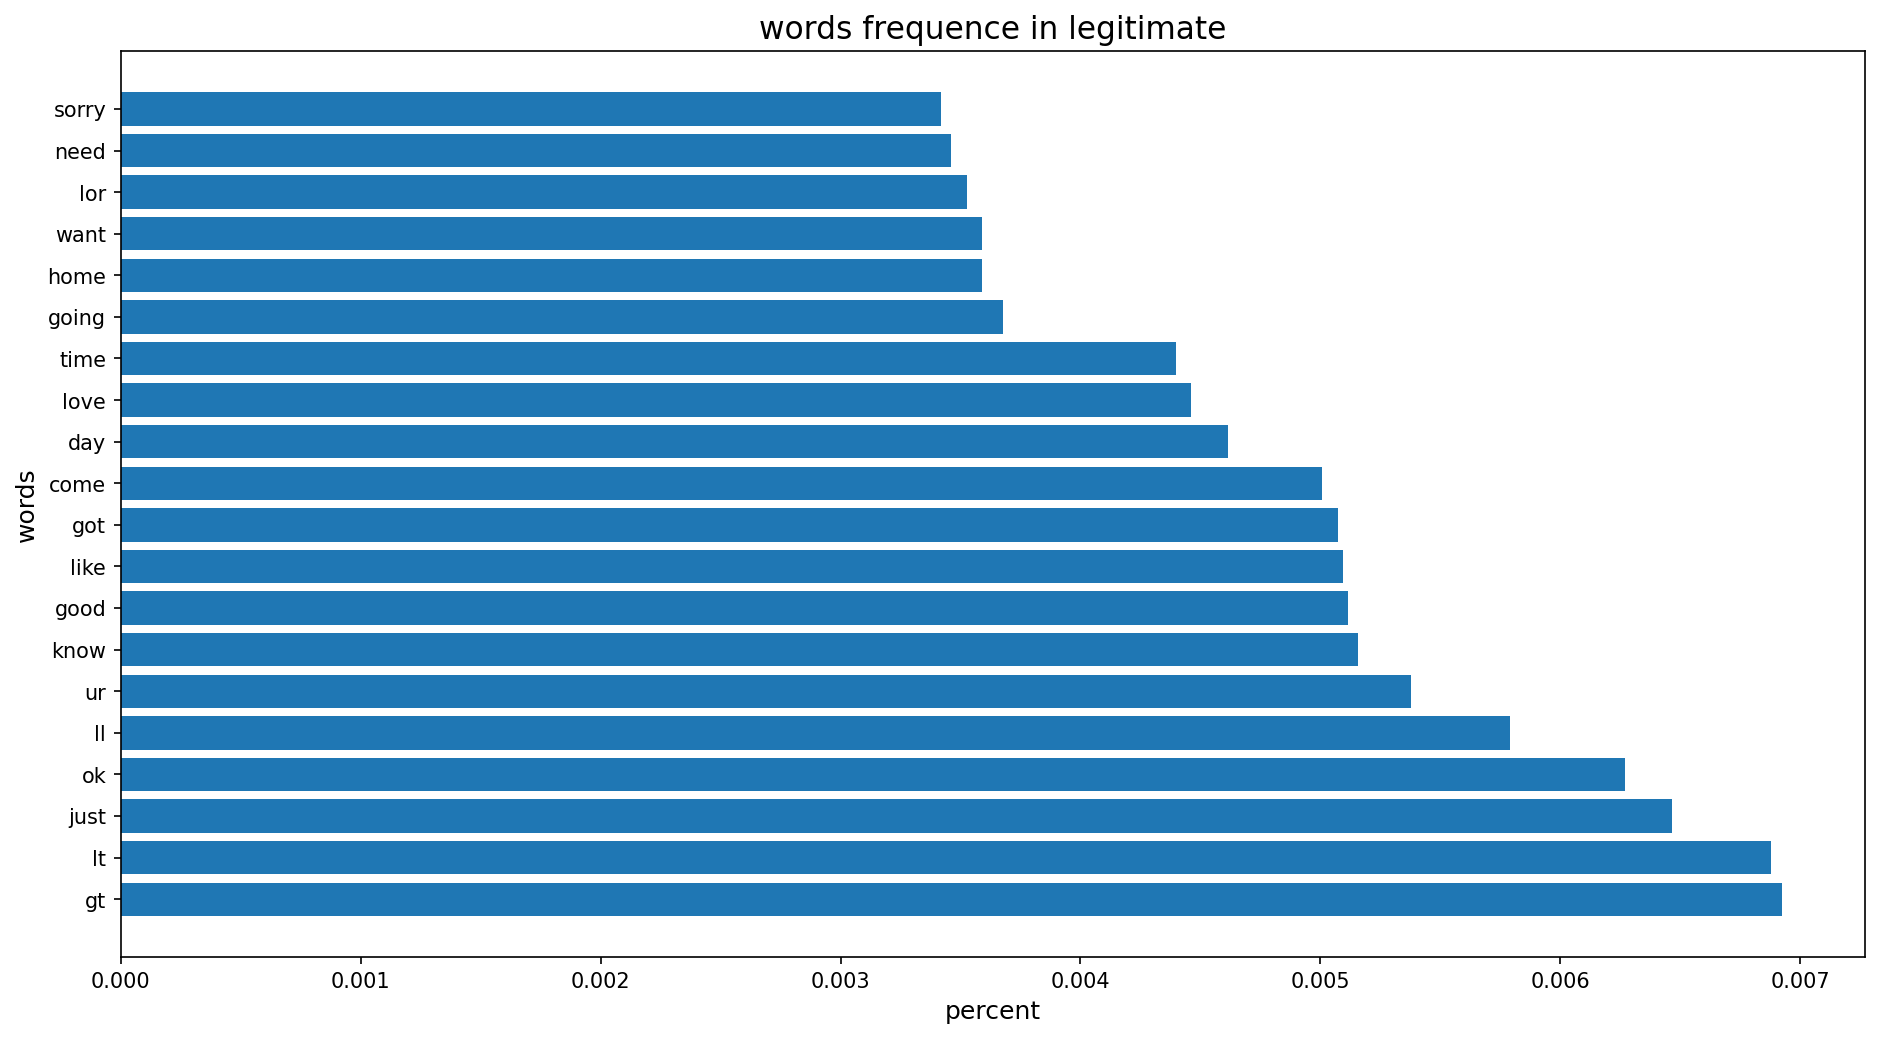

In [10]:
plt.figure(figsize = (15, 8), dpi = 150)
plt.barh(y = top_20_words['word'], width = top_20_words['Freq']/word_freq['Freq'].sum())
plt.xlabel('percent', size = 12)
plt.ylabel('words', size = 12)
plt.title('words frequence in legitimate', size = 15)
plt.show()

In [11]:
## class spam(spam messages)
spam = data[data['label'] == 'spam']['text'].values
spam_freq = getFreq(spam)
top_20_words = spam_freq.sort_values('Freq', ascending= False).head(20)

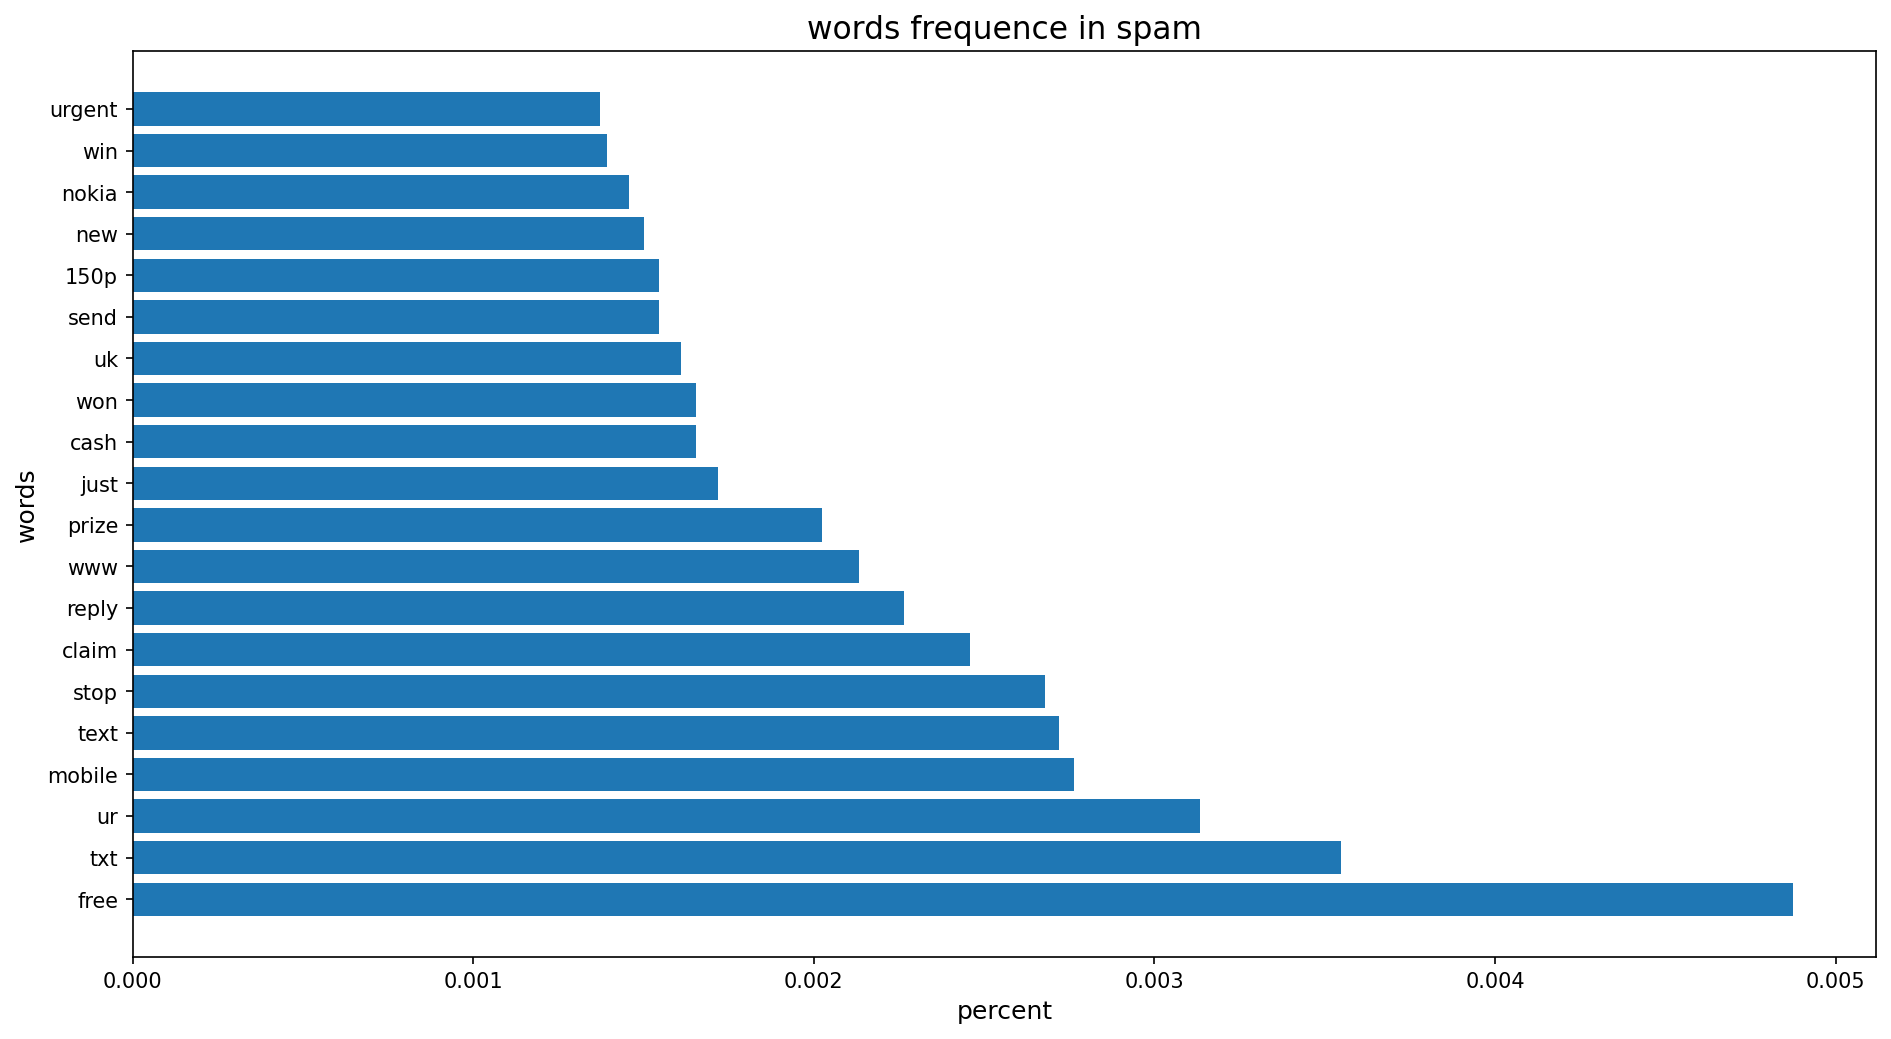

In [12]:
plt.figure(figsize = (15, 8), dpi = 150)
plt.barh(y = top_20_words['word'], width = top_20_words['Freq']/word_freq['Freq'].sum())
plt.xlabel('percent', size = 12)
plt.ylabel('words', size = 12)
plt.title('words frequence in spam', size = 15)
plt.show()

#### Create model

In [13]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier

In [14]:
## label encoder for label attribute
data['label'] = data['label'].apply(lambda x: 1 if x == 'ham' else 0)

In [15]:
## split train and test with 0.8; 0.2 
train_X, test_X, train_y, test_y = train_test_split(data['text'], data['label'], test_size = 0.2, shuffle = True)
len(train_X), len(test_X)

(4459, 1115)

In [44]:
## Text preprocessing
## i use TF-IDF method of sklearn.
tfidf = TfidfVectorizer(stop_words= 'english', ngram_range= (1, 1))
tfidf.fit(train_X)
tfidf_train = tfidf.transform(train_X)
tfidf_test = tfidf.transform(test_X)
print('shape of train and test after apply tf-idf: {}, {}'.format(tfidf_train.shape, tfidf_test.shape))

shape of train and test after apply tf-idf: (4459, 7538), (1115, 7538)


#### Choosing model using cross_val_score

In [45]:
## evaluate model
def evaluate(model, name_model, X,y):
    scores = cross_val_score(model, X,y, cv=KFold(n_splits = 10, shuffle=True), scoring= 'f1')
    print('Model: {}\n'.format(name_model))
    print('Mean f1-score : {}\n\n'.format(scores.mean()))

In [46]:

models = {
    'MultinomialNB': MultinomialNB(),
    'RandomForestClassifier' : RandomForestClassifier(n_estimators=100),
    'ExtraTreesClassifier' : ExtraTreesClassifier(n_estimators = 100),
    'SVC' : SVC()
}

# choose best model
for name, model in models.items():
    evaluate(model, name, tfidf_train, train_y)

Model: MultinomialNB

Mean f1-score : 0.9845274813898826


Model: RandomForestClassifier

Mean f1-score : 0.986405710527335


Model: ExtraTreesClassifier

Mean f1-score : 0.9897120374454392


Model: SVC

Mean f1-score : 0.9840131668408929




##### GridSearch with ExtraTrees and n-grams

In [37]:
from sklearn.pipeline import make_pipeline, Pipeline

params = {
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)],
    'extree__n_estimators': [100, 250, 500, 1000, 1500],
    'extree__min_samples_split': [2, 5, 8, 10, 16]
}
kfold = KFold(n_splits = 5, random_state = 42, shuffle = True)

# create a pipeline to apply a list of transform and final estimator.
est = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words= 'english', ngram_range=(1, 1))),
    ('extree', ExtraTreesClassifier())
])

Search = GridSearchCV(estimator= est, param_grid = params, cv = kfold, scoring= 'f1', verbose= 2, n_jobs= -1)
Search.fit(train_X, train_y)
print('Best Scores: ', Search.best_score_)
print('Best params: ', Search.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Scores:  0.9890699062821564
Best params:  {'extree__min_samples_split': 5, 'extree__n_estimators': 100, 'tfidf__ngram_range': (1, 1)}


In [39]:
est.set_params(**Search.best_params_)
est.fit(train_X, train_y)

Pipeline(steps=[('tfidf', TfidfVectorizer(stop_words='english')),
                ('extree', ExtraTreesClassifier(min_samples_split=5))])

##### Evaluate model

F1 scores for train:  1.0
F1 scores for test:  0.992827868852459


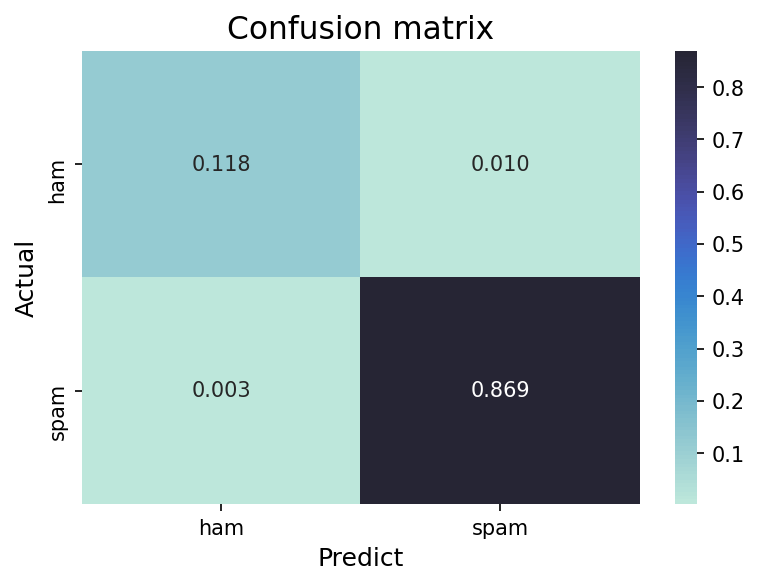

In [43]:
y_preds = est.predict(train_X)
print('F1 scores of train: ', f1_score(train_y, y_preds))
test_preds = est.predict(test_X)
print('F1 scores of test: ', f1_score(test_y, test_preds))

# confusion matrix
conf = confusion_matrix(test_y, test_preds)
conf = conf/len(test_y)
plt.figure(dpi = 150)
sns.heatmap(conf, annot= True, center= True, fmt = '.3f',\
            xticklabels= ['ham', 'spam'] , yticklabels= ['ham', 'spam'])
plt.xlabel('Predict', size = 12)
plt.ylabel('Actual', size = 12)
plt.title('Confusion matrix', size = 15)
plt.show()

F1 scores of train with navie bayes model:  0.9893494161426922
F1 scores of test with navie bayes model:  0.9833080424886191


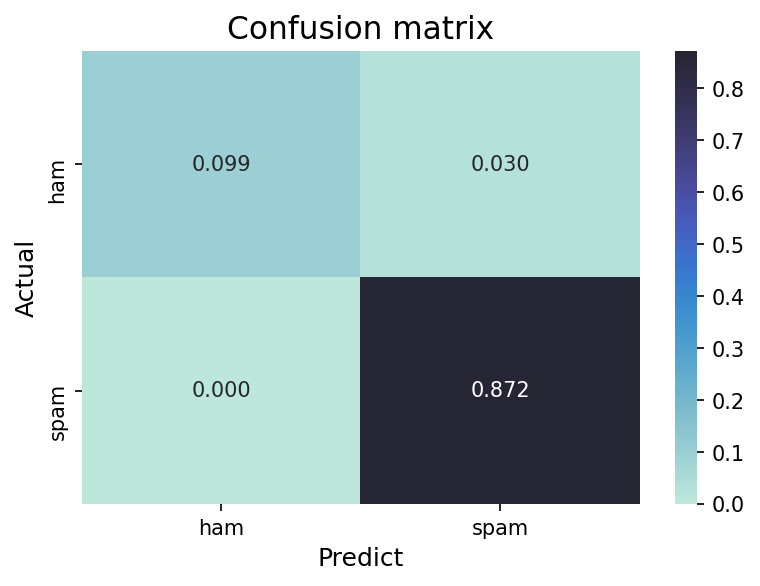

In [48]:
# Naive_bayes model
nb = MultinomialNB()
nb.fit(tfidf_train, train_y)
y_preds = nb.predict(tfidf_train)
print('F1 scores of train with navie bayes model: ', f1_score(train_y, y_preds))
test_preds = nb.predict(tfidf_test)
print('F1 scores of test with navie bayes model: ', f1_score(test_y, test_preds))
# confusion matrix
conf = confusion_matrix(test_y, test_preds)
conf = conf/len(test_y)
plt.figure(dpi = 150)
sns.heatmap(conf, annot= True, center= True, fmt = '.3f',\
            xticklabels= ['ham', 'spam'] , yticklabels= ['ham', 'spam'])
plt.xlabel('Predict', size = 12)
plt.ylabel('Actual', size = 12)
plt.title('Confusion matrix', size = 15)
plt.show()

F1 scores of train with support vecter machine model:  0.9989634620367971
F1 scores of test with support vecter machine model:  0.9892911779704232


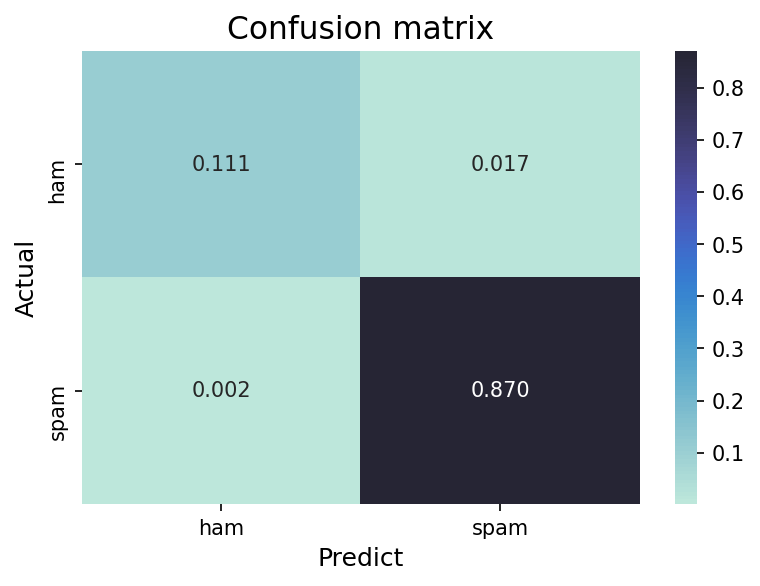

In [49]:
# SVC model
svc = SVC()
svc.fit(tfidf_train, train_y)
y_preds = svc.predict(tfidf_train)
print('F1 scores of train with support vecter machine model: ', f1_score(train_y, y_preds))
test_preds = svc.predict(tfidf_test)
print('F1 scores of test with support vecter machine model: ', f1_score(test_y, test_preds))
# confusion matrix
conf = confusion_matrix(test_y, test_preds)
conf = conf/len(test_y)
plt.figure(dpi = 150)
sns.heatmap(conf, annot= True, center= True, fmt = '.3f',\
            xticklabels= ['ham', 'spam'] , yticklabels= ['ham', 'spam'])
plt.xlabel('Predict', size = 12)
plt.ylabel('Actual', size = 12)
plt.title('Confusion matrix', size = 15)
plt.show()